## About this Notebook

In this kernel, I will do exploratory data analysis mainly using files in directory `train_files` to facilitate the preliminary understanding of the data; also, a simple baseline model will be implemented to illustrate the usage of times series API.

## Table of Contents

 - 1.`stock_prices.csv`
   - File Description
   - Simple summary
   - Primary Key
   - Missing Values
   - Target Exploration
   - Stock List Fusion
   - Secondary Stocks

## Import Packages

In [1]:
# !pip install plotly

In [2]:
import os
import gc
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# configuration
warnings.simplefilter('ignore')
pd.set_option('display.max_column', None)
sns.set_style('darkgrid')
colors = sns.color_palette('Set2')

In [3]:
TRAIN_DIR = './jpx_data/train_files'

## Load Data

Let's load data first. It doesn't take too much time!

In [4]:
%%time

df_prices = pd.read_csv(os.path.join(TRAIN_DIR, 'stock_prices.csv'))
df_prices_sec = pd.read_csv(os.path.join(TRAIN_DIR, 'secondary_stock_prices.csv'))
df_fins = pd.read_csv(os.path.join(TRAIN_DIR, 'financials.csv'))
df_opts = pd.read_csv(os.path.join(TRAIN_DIR, 'options.csv'))
df_trades = pd.read_csv(os.path.join(TRAIN_DIR, 'trades.csv'))
stock_list = pd.read_csv(os.path.join('./jpx_data/stock_list.csv'))

CPU times: user 19.9 s, sys: 3.67 s, total: 23.6 s
Wall time: 24.2 s


## stock_prices.csv

### File Description

The core file of interest, including the daily closing price for each stock and the target column. Following is column information recorded in `stock_price_spec.csv`:

 - `RowId`: Unique ID of price records, the combination of `Date` and `SecuritiesCode`.
 - `Date`: Trade date.
 - `SecuritiesCode`: Local securities code.
 - `Open`: First traded price on a day.
 - `High`: Highest traded price on a day.
 - `Low`: Lowest traded price on a day.
 - `Close`: Last traded price on a day.
 - `Volume`: Number of traded stocks on a day.
 - `AdjustmentFactor`: Used to calculate theoretical price/volume when split/reverse-split happens (NOT including dividend/allotment of shares).
 - `ExpectedDividend`: Expected dividend value for ex-right date. This value is recorded 2 business days before ex-dividend date.
 - `SupervisionFlag`: Flag of securities under supervision and securities to be delisted, for more information.
 - `Target`: Change ratio of adjusted closing price between t+2 and t+1 where t+0 is trade date.

### Simple Summary

`ExpectedDividend` has severe missing, which is related to the ''frequency of dividends paid''. Also, there are some missing prices to notice.

In [5]:
def summarize(df, file_name, n_rows_to_show=5):
    '''Simply summarize the given DataFrame.
    
    Parameters:
        df : pd.DataFrame, raw DataFrame
        file_name: str, name of the file
        n_rows_to_show: int, number of rows to show
    
    '''
    
    print(f'=======Summary of {file_name}=======')
    print(f'Shape: {df.shape}')
    
    nan_ratio = pd.isnull(df).sum() / len(df) * 100
    nan_ratio.sort_values(ascending=False, inplace=True)
    nan_ratio = nan_ratio.to_frame(name='NaN Ratio').T
    print('NaN ratio:')
    display(nan_ratio)
    
    display(df.head(n_rows_to_show))

In [6]:
summarize(df_prices, 'stock_prices.csv')

=======Summary of stock_prices.csv=======
Shape: (2332531, 12)
NaN ratio:


,ExpectedDividend,Open,High,Low,Close,Target,RowId,Date,SecuritiesCode,Volume,AdjustmentFactor,SupervisionFlag
NaN Ratio,99.191222,0.326169,0.326169,0.326169,0.326169,0.010204,0.0,0.0,0.0,0.0,0.0,0.0


,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


## Primary Key

`RowID` is composed of `Date` and `SecuritiesCode`.

In [7]:
row_id = (df_prices['Date'].apply(lambda date: ''.join(date.split('-'))) + '_') + (df_prices['SecuritiesCode'].astype(str))

assert (df_prices['RowId'] == row_id).all(), 'Transformation is not correct.'
## Force to check above processing is corret.

In [8]:
n_dates = df_prices['Date'].nunique()
date_min, date_max = df_prices['Date'].min(), df_prices['Date'].max()
n_stocks = df_prices['SecuritiesCode'].nunique()

print(f'Number of unique dates: {n_dates} ({date_min} ~ {date_max})\n'
      f'Number of unique stocks: {n_stocks}')



Number of unique dates: 1202 (2017-01-04 ~ 2021-12-03)
Number of unique stocks: 2000


Over 90% of stocks have records for complete training period from `2017-01-04` to `2021-12-03`. However, we still need to pay attention to 'missing values' in certain columns(e.g., `ExpectedDividend`, price columns).

`Number of unique stocks: 2000`에 해당하는 stock(종목) 중 약 90%에 해당하는 stock(종목)들은 데이터에 주어진 기간(dates)에 모두 trading(거래) 되었다.

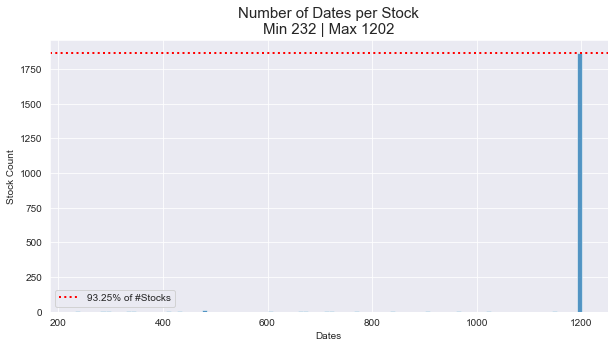

In [9]:
n_dates_per_stock = df_prices.groupby(['SecuritiesCode'])['Date'].count()
stock_cnt_max = (n_dates_per_stock == n_dates_per_stock.max()).sum()
stock_ratio_max = stock_cnt_max / len(n_dates_per_stock) * 100

fig, ax = plt.subplots(figsize = (10, 5))
sns.histplot(data=n_dates_per_stock.values, bins=100, palette=colors, ax=ax)

ax.axhline(y=stock_cnt_max, color='red', linestyle='dotted', linewidth=2, label=f'{stock_ratio_max}% of #Stocks')
ax.legend()

ax.set_title(f'Number of Dates per Stock\nMin {n_dates_per_stock.min()} | '
             f'Max {n_dates_per_stock.max()}', fontsize=15)

ax.set_xlabel('Dates')
ax.set_ylabel('Stock Count')

plt.show()

Approximately 20% of trading dates have all 2000 stocks' records. Again, the missing values should be noted.

`Number of unique dates: 1202 (2017-01-04 ~ 2021-12-03)`에 해당하는 거래일자중 약 20%에 해당하는 거래일자는 데이터에 주어진 2000종류의 stock(종목)이 모두 거래되었다.

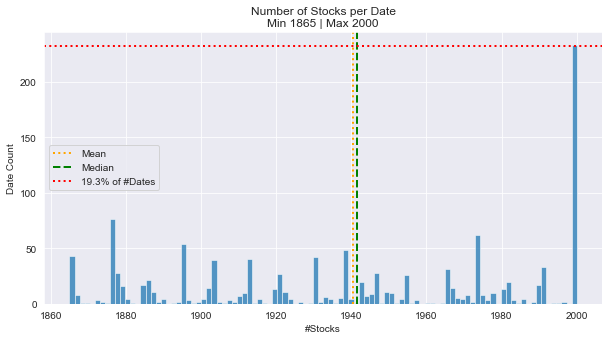

In [10]:
n_stocks_per_date = df_prices.groupby(['Date'])['SecuritiesCode'].count()

date_cnt_max = (n_stocks_per_date == n_stocks_per_date.max()).sum()

date_ratio_max = round(date_cnt_max / len(n_stocks_per_date) * 100, 2)


fig, ax = plt.subplots(figsize = (10, 5))

sns.histplot(data=n_stocks_per_date.values, bins=100, palette=colors, ax=ax)

ax.axvline(x=n_stocks_per_date.mean(), color='orange', linestyle='dotted', linewidth=2, label='Mean')
## 일자별 평균 거래량
ax.axvline(x=n_stocks_per_date.median(), color='green', linestyle='--', linewidth=2, label='Median')
## 일자별 거래량 중앙값
ax.axhline(y=date_cnt_max, color='red', linestyle='dotted', linewidth=2, label=f'{date_ratio_max}% of #Dates')

ax.set_title(f'Number of Stocks per Date\nMin {n_stocks_per_date.min()} | '
             f'Max {n_stocks_per_date.max()}')

ax.set_xlabel('#Stocks')
ax.set_ylabel('Date Count')
plt.legend()
plt.show()

### Missing Values

Let's focus on records with <span style = 'font-weight: bold'>missing prices</span>.

In [21]:
df_no_prices = df_prices[df_prices['Close'].isna()]
print(f"Number of samples without prices: {len(df_no_prices)}")

Number of samples without prices: 7608


Number of stocks without prices has a maximum on `2020-10-01 (1988 stocks has no prices)`. After doing some research, I find that it's because of The Failure of Equity Trading System on October 1, 2020. 

가격 정보가 나와있지 않는 stocks의 maximum은 2020-10-01에 관측된다. 그리고 이는 2020-10-01에 있었던 주식매매시스템상의 문제 때문인것으로 추측된다.

In [56]:
no_prices_per_date = df_no_prices['Date'].value_counts().sort_index()

all_dates = sorted(df_prices['Date'].unique())

no_prices_per_date = no_prices_per_date.reindex(all_dates, fill_value=0)
## no_price가 하나도 없는 일자에는 0을 넣어줌.

fig = go.Figure()

fig.add_trace(go.Scatter(x = no_prices_per_date.index,
                         y = no_prices_per_date,
                         mode = 'lines'))

rect_focus_params = {
    'xref': 'x', 'yref': 'y', 'x0': '2020-09-25', 'x1': '2020-10-08', 'y0': 1900, 'y1':2000, 'line': {'color': 'red', 'width': 1.5}
}
fig.add_shape(type='rect', **rect_focus_params)
fig.update_layout(
    title = "Number of Stocks without Prices per Date",
    xaxis_title = 'Date',
    yaxis_title = 'Stock Count'
)


fig.show()


no_prices_per_date[no_prices_per_date == no_prices_per_date.max()]

2020-10-01    1988
Name: Date, dtype: int64

In [62]:
assert (len(df_prices[df_prices['Date'] == '2020-10-01']) == no_prices_per_date.max(), 
       'There are some sample that has price on Date 2020-10-01')

## Check to see the sample that has a price on Date 2020-10-01.

Over 90% of stocks have only one date with missing prices. And, the culprit is mainly the one I mentioned above, `2020-10-01`.

가격정보가 나타나지 않는 샘플들중 90% 이상이 단 하루만 가격정보가 나타나지 않는다. 그 이유는 위에서 관측했던 2020-10-01 시스템상 문제로 인한것으로 추측 된다. 

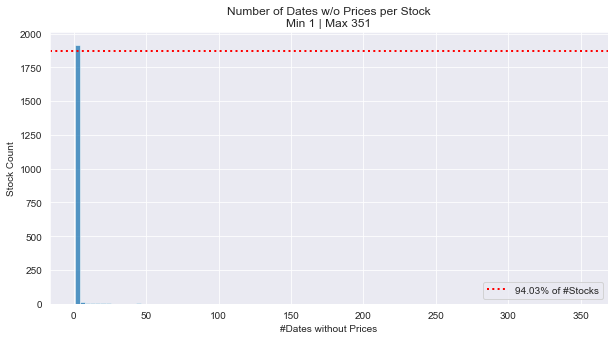

In [76]:
no_prices_per_stock = df_no_prices['SecuritiesCode'].value_counts()

stock_cnt_max = (no_prices_per_stock.min() == no_prices_per_stock).sum()

stock_ratio_max = round(stock_cnt_max / len(no_prices_per_stock) * 100, 2)

fig, ax = plt.subplots(figsize = (10, 5))

sns.histplot(data=no_prices_per_stock.values, bins=100, palette=colors, ax=ax)
ax.axhline(y = stock_cnt_max, color='red', linestyle='dotted', linewidth=2, label=f'{stock_ratio_max}% of #Stocks')
ax.legend()

ax.set_title(f'Number of Dates w/o Prices per Stock\n'
             f'Min {no_prices_per_stock.min()} | '
             f'Max {no_prices_per_stock.max()}')

ax.set_xlabel('#Dates without Prices')
ax.set_ylabel('Stock Count')

plt.show()

### Target Exploration

Let's observe the behavior of target along with OHLCV plot!


In [79]:
df_ = df_prices.copy() if True else df_prices_sec.copy()

In [92]:
df_ = df_[df_['SecuritiesCode'] == 1301]
dates = df_['Date'].values

ohlc = {
    'open': df_['Open'].values,
    'high': df_['High'].values,
    'low': df_['Low'].values,
    'close': df_['Close'].values
}
vol = df_['Volume'].values
target = df_['Target'].values

fig = make_subplots(rows=3, cols=1, shared_xaxes=True, x_title='Date')

fig.add_trace(go.Candlestick(x=dates, name='OHLC', **ohlc), row=1, col=1)
fig.add_trace(go.Bar(x=dates, y=vol, name='Volume'), row=2, col=1)
fig.add_trace(go.Scatter(x=dates, y=target, name='Target'), row=3, col=1)
fig.update_layout(
    title = f'OHLCV Chart with Target Series (Stock {1301})'
)
fig.update(layout_xaxis_rangeslider_visible=False)

fig.show()

In [93]:
def plot_candle_with_target(stock_code, prime=True):
    '''Plot OHLCV plot with target series.
    
    Parameters:
        stock_code: int, code of the stock
        prime: bool, whether the stock to plot is prime or not
    
    '''
    df_ = df_prices.copy() if prime else df_prices_sec.copy()
    df_ = df_[df_['SecuritiesCode'] == stock_code]
    dates = df_['Date'].values
    ohlc = {
        'open': df_['Open'].values,
        'high': df_['High'].values,
        'low': df_['Low'].values,
        'close': df_['Close'].values
    }
    vol = df_['Volume'].values
    target = df_['Target'].values
    
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, x_title='Date')
    fig.add_trace(go.Candlestick(x=dates, name='OHLC', **ohlc), row=1, col=1)
    fig.add_trace(go.Bar(x=dates, y=vol, name='Volume'), row=2, col=1)
    fig.add_trace(go.Scatter(x=dates, y=target, name='Target'), row=3, col=1)
    
    fig.update_layout(
        title = f'OHLCV Chart with Target Series (Stock {stock_code})'
    )
    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.show()

In [94]:
for stock_code in df_prices['SecuritiesCode'].unique()[:3]:
    plot_candle_with_target(stock_code)

----------------------------------------------------------

## 참고 자료

 - garbage collection(GC): https://medium.com/dmsfordsm/garbage-collection-in-python-777916fd3189

In [11]:
import sys

In [12]:
a = 'hello world'
print(sys.getrefcount(a))

b = [a, a, a]
print(sys.getrefcount(a))

c = {'first': a}
print(sys.getrefcount(a))

3
6
7


In [13]:
import gc
gc.get_threshold()

(700, 10, 10)

In [14]:
gc.get_count()

(110, 0, 8)

In [15]:
gc.collect()

9145

In [16]:
gc.get_count()

(111, 0, 0)